In [1]:
import os
import sys
import warnings

import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import random
import soundfile as sf
import torch
import torch.nn as nn
from keras.layers import Input, Conv2D, MaxPooling2D, GRU, Dense, Reshape, Flatten
from keras.models import Model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torchsummary import summary
from torch.utils.data import DataLoader
from tqdm import tqdm
from pydub import AudioSegment


/home/omega/anaconda3/lib/python3.8/site-packages/lazy_loader/__init__.py:185: RuntimeWarning: subpackages can technically be lazily loaded, but it causes the package to be eagerly loaded even if it is already lazily loaded.So, you probably shouldn't use subpackages with this lazy feature.
  warnings.warn(msg, RuntimeWarning)
/home/omega/anaconda3/lib/python3.8/site-packages/lazy_loader/__init__.py:185: RuntimeWarning: subpackages can technically be lazily loaded, but it causes the package to be eagerly loaded even if it is already lazily loaded.So, you probably shouldn't use subpackages with this lazy feature.
  warnings.warn(msg, RuntimeWarning)


In [2]:
# ----- main -------------------------------------------------------------------------
#!mkdir temp

# --> Load Files
def load(paths):
    if type(paths) == str : return np.load(paths)
    values = []
    
    for path in paths:
        var = np.load(path)
        values.append(var)
    
    return np.array(values)

# --> Save DataFrames
def save_df(file, name):
    newData_path = name
    file.to_csv(f'{newData_path}.csv', index=False)  # Save as CSV file
    
# ----- Tools -------------------------------------------------------------------------

# --> check a varible size in mb
def tool_var_size(var):
    size_in_bytes = sys.getsizeof(var)
    size_in_mb = size_in_bytes / (1024 * 1024)
    print(f"The size is {size_in_mb:.2f} MB.")

# --> check RAM size
def tool_ram_size():    
    vm_stats = psutil.virtual_memory()
    available_str = psutil._common.bytes2human(vm_stats.available)
    
    print("Available memory: {}".format(available_str))
    
# ----- Audio -------------------------------------------------------------------------

# --> play [spectrogram]
def audio_play_spec(spec, name='spec_to_audio', target_dbfs= -24):    
    audio = librosa.istft(spec)
  
    newData_path = os.path.join('temp', f'{name}.wav')

    sf.write(newData_path, audio, 22050) # to convert it to AudioSegment type
    audio = AudioSegment.from_file(newData_path)
    
    current_dbfs = audio.dBFS
    gain_needed = target_dbfs - current_dbfs
    audio = audio + gain_needed
    return audio

# ----- Spectogram -------------------------------------------------------------------------

# --> visualization  
def spec_visualize(spec):
    librosa.display.specshow((spec), sr=22050, x_axis='time', y_axis='log')

# --> Applay mask on Spectrogram
def spec_applay_mask(spec_path, mask_path):
    
    spec = np.load(spec_path) if isinstance(spec_path, str) else spec_path
    mask = np.load(mask_path) if isinstance(mask_path, str) else mask_path        
    
    masked_spectrogram = spec * mask   
    return masked_spectrogram

# ----- Mask -------------------------------------------------------------------------

# convert vector to masks
def mask_vector_resahpe(vector, num_frequency_bins = 1025):
    masks = vector.reshape(num_frequency_bins,-1)
    
    coulmns = int(masks.shape[1]/3)

    mask_1 = masks[:, :coulmns]
    mask_2 = masks[:, coulmns:coulmns*2]
    mask_3 = masks[:, coulmns*2:]
    
    return mask_1, mask_2, mask_3

In [3]:
# ----- Divider -------------------------------------------------------------------------
class Divider():
    def __init__(self, dataFrame, num_groups):  
        self.df = dataFrame
        self.size = num_groups
        self.data = []
    
    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

    def divide(self):
        shuffled_df = self.df.sample(frac=1)
        
        s = 0
        e = self.size

        while e <= len(self.df):
            self.data.append(self.df[s:e])
           
            s = e
            e += self.size
            
        return self.data

# ----- Batch -------------------------------------------------------------------------
class Batch:
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def get_items(self):
        
        spec = torch.from_numpy(load(self.data['spectrogram']).real)
        vec = torch.from_numpy(load(self.data['vector']))
        
        spec = torch.unsqueeze(spec, dim=1)
        return spec, vec


In [4]:
# ----- CNN -------------------------------------------------------------------------
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
       
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2))
        
        self.flatten = nn.Flatten()

    def forward(self, x):
        # [Batch, Channels, Height, Width]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.flatten(x)

        return x

# ----- RNN -------------------------------------------------------------------------
class RNN(nn.Module):
    def __init__(self, input_size):
        super(RNN, self).__init__()
        self.lstm1 = nn.LSTM(input_size, 128)
        self.lstm2 = nn.LSTM(128, 256)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        #[Batch, TimeSteps, Features]
        x, _ = self.lstm1(x)
        x  = self.relu(x)
        x, _ = self.lstm2(x)
        
        return x  

    
# ----- Combined Model -------------------------------------------------------------------------
class CombinedModel(nn.Module):
    def __init__(self, cnn_size):
        super(CombinedModel, self).__init__()        
        self.cnn = CNN()
        self.rnn = RNN(cnn_size)
        
        self.fc1 = nn.Linear(256, 512)   
        self.fc2 = nn.Linear(512, 267525)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        
        cnn_output = self.cnn(x)
        rnn_output = self.rnn(cnn_output) 
        
        x = self.relu(rnn_output)
        x = self.fc1(x)
        
        x = self.dropout(x)
        x = self.fc2(x)
        
        x = self.sigmoid(x)
        return x

In [5]:
###### ----- Read DataFram -------------------------------------------------------------------------
length = 160

df = pd.read_csv('Final_dataSet.csv')
df = df[:length]
df = df[['spectrogram', 'vector']]

# ----- Split Data -------------------------------------------------------------------------

train, test = train_test_split(df, test_size=0.1)

# ----- HyperParameters -------------------------------------------------------------------------

lr = 0.001
num_epochs = 20

loss_values = []
average_loss = 0

# ----- Initialize Model -------------------------------------------------------------------------

device = torch.device("cuda")

model = CombinedModel(344064).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr =lr)

# ----- Start Training  -------------------------------------------------------------------------

for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    
    batch_size = 16
    Batchs = Divider(train, batch_size ).divide()
    
# ===== Read Batch =================================================================================

    for batch in Batchs:        
            spec, vector = Batch(batch).get_items()
            
            spec = spec.to(device)
            vector = vector.to(device).float()
            
# ===== Training =================================================================================    

            outputs = model(spec).float()

            loss = criterion(outputs, vector)
            total_loss += loss.item()
            loss_values.append(loss.item())
                        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# ===== Print Results =================================================================================

    if int(average_loss*1000) == int((total_loss / len(Batchs)  )*1000) : 
        average_loss = total_loss / len(Batchs)
        print(f"Epoch {epoch+1}, Average Loss: {average_loss:.4f} || Over Fitting")
        num_epochs = epoch + 1
        break
        
    average_loss = total_loss / len(Batchs) 
    print(f"Epoch {epoch+1}, Average Loss: {average_loss:.4f}")

  5%|▌         | 1/20 [00:31<09:54, 31.28s/it]

Epoch 1, Average Loss: 0.6158


 10%|█         | 2/20 [01:00<09:03, 30.19s/it]

Epoch 2, Average Loss: 0.1897


 15%|█▌        | 3/20 [01:29<08:25, 29.75s/it]

Epoch 3, Average Loss: 0.1417


 20%|██        | 4/20 [01:59<07:53, 29.61s/it]

Epoch 4, Average Loss: 0.1152


 25%|██▌       | 5/20 [02:28<07:21, 29.46s/it]

Epoch 5, Average Loss: 0.1071


 30%|███       | 6/20 [02:57<06:52, 29.44s/it]

Epoch 6, Average Loss: 0.1027


 35%|███▌      | 7/20 [03:27<06:21, 29.37s/it]

Epoch 7, Average Loss: 0.1003


 40%|████      | 8/20 [03:56<05:52, 29.38s/it]

Epoch 8, Average Loss: 0.0987


 40%|████      | 8/20 [04:25<06:38, 33.22s/it]

Epoch 9, Average Loss: 0.0983 || Over Fitting


In [76]:
mask = 0
def calculate_accuracy(model, spec, vec= None):
    model.eval()
    
    with torch.no_grad():
        spec = spec.reshape(1,1,1025,87)
        inputs = torch.tensor(spec).real 
        
        outputs = model(inputs)
        outputs = torch.round(outputs).T.cpu()
        return outputs

        if type(vec) == None : return outputs

        ground_truth = vec
        accuracy = accuracy_score(ground_truth, outputs)*100
        
        print(f"Accuracy is {accuracy:.2f} %")
    return accuracy

X, y = df['spectrogram'], df['vector']
spec = load(X[5])
vec = load(y[5])

mask = calculate_accuracy(model.cpu(), spec, vec)

In [77]:
plt.close('all')
mask = mask.numpy()
mask = np.array(mask, dtype=np.int32)
mask = mask.T

In [78]:
plt.close('all')
m1, m2, m3 = mask_vector_resahpe(vec)

In [81]:
audio_play_spec(spec_applay_mask(m3,spec))

In [61]:
vec

array([0, 0, 0, ..., 0, 0, 0])

,Trial,Length,Epochs,Batch Size,Learning Rate,Loss,Accuracy
0,"droupOut, lr,",2000,3,180,0.01000,0.109534,0.968209
1,lr,2000,5,180,0.00100,0.098949,0.969879
2,Fault,2000,4,180,0.00100,0.396991,0.969285
3,Create Batch Class,100,2,7,0.00100,0.061671,96.967386
4,Clean Code,1600,4,16,0.00100,0.006418,96.999159
5,Big Length,10000,6,24,0.00100,0.004131,96.998785
6,Test,3200,6,16,0.00100,0.006392,96.997664
7,Added The Bach Norm,3200,6,16,0.00100,0.007117,96.999159
8,Testing epochs_1,1600,6,16,0.00100,0.008355,96.999159
9,Testing epochs_2,1600,6,24,0.00100,0.006348,96.999159


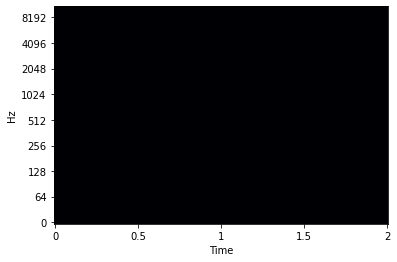

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [44]:
msg = 'lstm 256'
prog = pd.read_csv('progress.csv')
row = {
    'Trial': [msg],
    'Length': [length],
    'Epochs': [num_epochs],
    'Batch Size': [batch_size],
    'Learning Rate': [lr],
    'Loss': [average_loss],
    'Accuracy': [test]
}

prog = prog.append(pd.DataFrame(row), ignore_index=True)
prog

In [8]:
save_df(prog, 'progress')